# Figures and computational analyses for Jankowski et al.
This Notebook contains code to recreate analyses and figures from the manuscript:

**The formation of a fuzzy complex in the negative arm regulates the robustness of the circadian clock** <br> Meaghan S. Jankowski, Daniel Griffith, Divya G. Shastry, Jacqueline F. Pelham, Garret M. Ginell, Joshua Thomas, Pankaj Karande, Alex S. Holehouse, and Jennifer M. Hurley

### Dependencies
This notebook requires the following additional Python packages that can be installed using `pip` and/or `conda`.

* **numpy** (version 1.22.0 used, but this is not a hard requirement) [Click here for installation info](https://numpy.org/install/)

* **pandas** (version 1.4.0 used, but this is not a hard requirement) [Click here for installation info](https://pandas.pydata.org/docs/getting_started/install.html)

* **matplotlib** (version 3.5.1 used but this is not a hard requirement) [Click here for installation info](https://matplotlib.org/stable/users/installing/index.html)

* **seaborn** (version 0.11.2 used but this is not a hard requirement) [Click here for installation info](https://seaborn.pydata.org/installing.html)

* **scipy** (version 1.7.3 used but this is not a hard requirement) [Click here for installation info](https://scipy.org/install/)

* **localcider** (version 0.1.19 used but this is not a hard requirement) [Click here for installation info](https://scipy.org/install/)

* **protfasta** (version 0.1.9 used but this is not a hard requirement) [Click here for installation info](https://protfasta.readthedocs.io/en/latest/installation.html)

* **metapredict** (version 2.2 - this is a hard requirement - uses legacy version of 2.2) [Click here for installation info](https://metapredict.readthedocs.io/en/latest/getting_started.html#installation)


### Ortholog alignment 
The set of aligned orthologs was generated using **Clustal Omega** version 1.2.3. For [installation guidelines see here](http://www.clustal.org/omega/) but this can also be done using the online Clustal Omega web server: [https://www.ebi.ac.uk/Tools/msa/clustalo/](https://www.ebi.ac.uk/Tools/msa/clustalo/).

### Conservation calculation
In addition, the amino acid conservation scores were calculated using the Python code developed by [Capra and Singh](https://academic.oup.com/bioinformatics/article/23/15/1875/203579). This code and all supporting data [are provided freely here](https://compbio.cs.princeton.edu/conservation/). In addition, [a webserver](https://compbio.cs.princeton.edu/conservation/score_conservation.cgi) is provided that enables the aligned set of orthologs provided in `/data` to be uploaded and the per-residue scores of the MSA to be calculated. 

For our analysis we used the **property entropy** mode with a **window-size** of 3 residues, a gap cutoff of 0.99 (not available to select in the web server) and the BLOSUM62 matrices. The computed numbers referenced against the ***N. crassa*** sequence are provided in `data/` under `ortholog_conservation.csv`.



In [21]:
# Built-in packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib
import seaborn as sns
import random
from scipy.stats import gaussian_kde

# external packages
from localcider.sequenceParameters import SequenceParameters
import protfasta
import metapredict as meta

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# Set font to arial
font = {'family' : 'arial'}
matplotlib.rc('font', **font)

## FRQ sliding feature plots
* Supplemental Figs 1A
* Main text Figs 3A

In [22]:
# Import dataset
dataset = 'data/peptide_binding_data.csv'
df = pd.read_csv(dataset)

# Focus on 3-shift scanning peptides
shift3 = df[df['seq_type'] == '3-shift']

In [23]:
# Get N- and C-terminal residue number for each peptide
shift3.loc[:, 'NTD'] = shift3.loc[:, 'idx']*3 - 2
shift3.loc[:, 'CTD'] = shift3.loc[:, 'idx']*3 + 12
shift3.loc[318, 'CTD'] = 989 # Manually change last peptide since it's only 14aa

# Get average binding score of each peptide that overlaps every position
avg_binding = []
for i in range(1, 990):
    peptides = shift3[shift3['NTD'] <= i]
    peptides = peptides[peptides['CTD'] >= i]
    avg_binding.append(np.mean(peptides['avg']))

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_8576/3742312712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift3.loc[:, 'NTD'] = shift3.loc[:, 'idx']*3 - 2
/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_8576/3742312712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift3.loc[:, 'CTD'] = shift3.loc[:, 'idx']*3 + 12


In [24]:
domain = np.arange(1, 990)
FRQ = 'MADSGDKSQGMRPPPFDSRGHPLPRRASPDKSITLENHRLARDTSSRVTSSSALGVTESQPQLKSSPTRRNSSGESEPTNWFNQSNRNPAAAFHDESHIMEVDPPFYQKETDSSNEESRYPPGRNPVHPPGGVQLPGFRPVAAHSSAADDYRSVIDDLTVENKRLKEELKRYKQFGSDVMRKEKLFEIKVHGLPRRKKRELEATLRDFAASLGDSSESTSQRRKTGRHGTAVHSSGVSLSKHDSSSSSRSRPVDSAYNSMSTGRSSHAPHSSGPSLGRPSLTRAKSVGTQKVENYLRDTPDGLLPHHIVMTDKEKKKLVVRRLEQLFTGKISGRNMQRNQSMPSMDAPLAPEGTNMAPPRPPPEGLREACIQLQDGDNPRKNRSSKDNGSASNSGGDQTELGGTGTGSGDGSGSGGRTGNNTSPPGAIAPDQRPTRPRDLDPDRVQIPSENMDYIRHLGLVSPEFLQGSRTSYQDVAPDAEGWVYLNLLCNLAQLHMVNVTPSFIRQAVSEKSTKFQLSADGRKIRWRGGTDGTKFSSDSSEDKSQQSPMTEDTEDGSDKNGRRKKRKTQQASSEIGRFGPSRSPSDTFHYKPMFVHRNSSSIETSLEESMSQGSEDAVDESNMGNSKWDFSGSGTTQQRRKRRYDGAIVYYTGAPFCTDLSGDPGDMSPTAQMTAGREVEGSGSGDEVEHVLQRTLSGSSLPIRPLSDDRARVAEVLDFDPGNPPELVADDGSSPNDEDFVFPWCEDPAKVRIQPIAKEVMEPSGLGGVLPDDHFVMLVTTRRVVRPILQRQLSRSTTSEDTAEFIAERLAAIRTSSPLPPRSHRLTVAPLQVEYVSGQFRRLNPAPLPPPAIFYPPFSTDSSWDDGDDLASDDEEVEEVEEDSYSEGQISRRANPHFSDNNTYMRKDDLAFDTETDVRMDSDDNRLSDSGHNMRAMMPRAEAVDGDDSPLAAVTGKEVDMLHTGSSVATAGGAESGYSSSMEDVSSS'

In [25]:
# KD hydropathy:
def sliding_window_KDhydropathy(seq, window_size):
    KD_SCALE = {'A':1.8, 'C':2.5, 'D':-3.5, 'E':-3.5, 'F':2.8, 
                'G':-0.4, 'H':-3.2, 'I':4.5, 'K':-3.9, 'L':3.8,
                'M':1.9, 'N':-3.5, 'P':-1.6, 'Q':-3.5, 'R':-4.5, 
                'S':-0.8, 'T':-0.7, 'V':4.2, 'W':-0.9, 'Y':-1.3}

    seq_hp = []
    for aa in seq:
        seq_hp.append(KD_SCALE[aa])
    seq_hp = np.array(seq_hp)

    windows = []
    sides = int((window_size-1)/2)
    for i in range(len(seq)):
        if i < sides:
            window = seq_hp[0:(i+sides+1)]
        elif i >= len(seq) - sides:
            window = seq_hp[(i-sides):]
        else:
            window = seq_hp[(i-sides):(i+sides+1)]
        windows.append(np.sum(window)/window_size)
    return np.array(windows)

In [26]:
# per-residue conservation scores (precomputed)
conservation_scores = np.loadtxt('data/ortholog_conservation.csv')


In [18]:
# Disorder (metapredict)

# Direct disorder
disorder = meta.predict_disorder(FRQ, legacy=True)
smooth_disorder = np.convolve(disorder, [0.2]*5, 'same')

# Fix boundaries
smooth_disorder[:2] = disorder[:2]
smooth_disorder[-2:] = disorder[-2:]

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_8576/2154517127.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_8576/2154517127.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels([0, 0, 200, 400, 600, 800, 1000], fontweight='bold', fontsize=14)


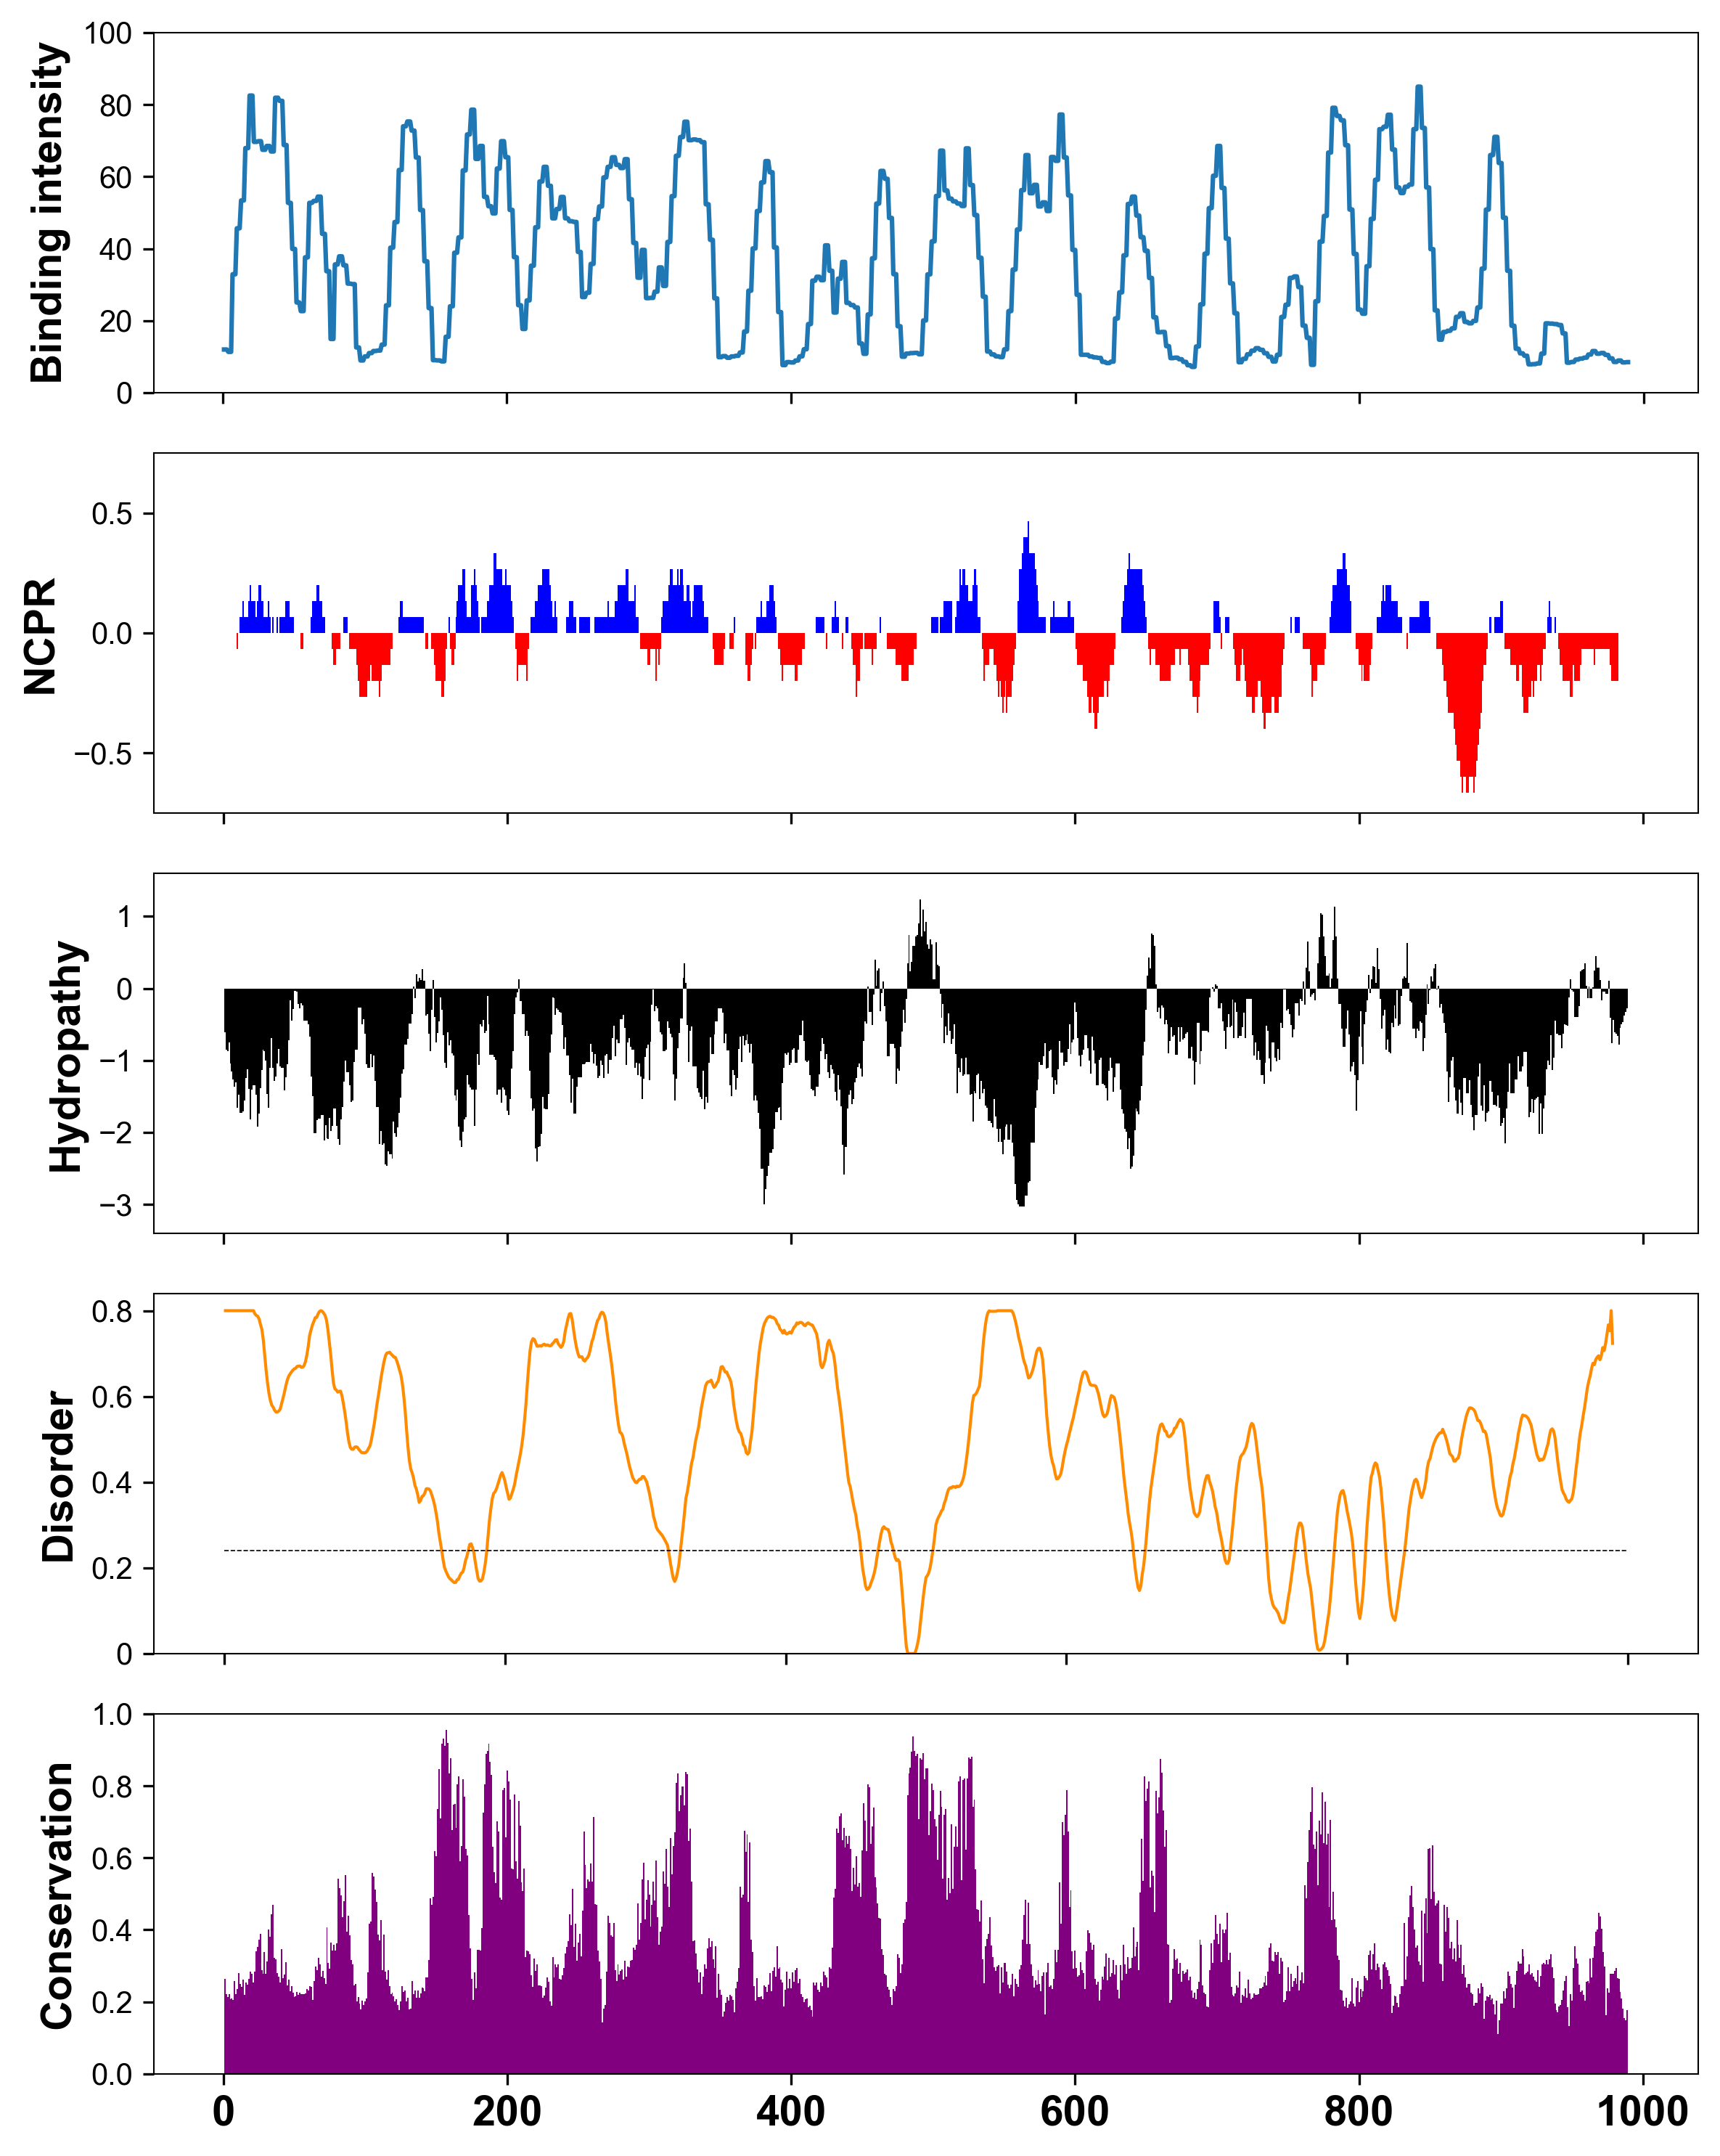

In [19]:
# Plot
fig, axs = plt.subplots(5,1, figsize=(8, 10), dpi=300)
ax1, ax2, ax3, ax4, ax5 = axs

# Avg binding over sequence
ax1.plot(domain, avg_binding)
ax1.set_ylabel('Binding intensity', fontweight='bold', fontsize=14)
ax1.set_ylim([0, 100])
ax1.set_xticklabels([])

# NCPR sliding window (window length=15)
seqOb = SequenceParameters(FRQ)
linNCPR = seqOb.get_linear_NCPR(blobLen=15)

positive_data = [x if x > 0 else 0 for x in linNCPR[1]]
negative_data = [x if x < 0 else 0 for x in linNCPR[1]]

ax2.bar(domain, negative_data, width=1, color='r')
ax2.bar(domain, positive_data, width=1, color='b')
ax2.set_ylim([-0.75, 0.75])
ax2.set_ylabel('NCPR', fontweight='bold', fontsize=14)
ax2.set_xticklabels([])

# Kyte-Doolittle hydropathy
ax3.bar(domain, sliding_window_KDhydropathy(FRQ, 15),  width=1, color='k')
ax3.set_ylim([-3.4, 1.6])
ax3.set_ylabel('Hydropathy', fontweight='bold', fontsize=14)
ax3.set_xticklabels([])

# Disorder
ax4.plot(np.arange(1,len(b.target_sequence)+1), smooth_disorder, color='darkorange', linewidth=1)
ax4.plot([0, 1000], [0.3]*2, 'k--', linewidth=0.4)
ax4.set_ylim([0, 1.05])
ax4.set_ylabel('Disorder', fontweight='bold', fontsize=14)
ax4.set_xticklabels([])
ax4.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

# Conservation
ax5.bar(np.arange(1,len(b.target_sequence)+1), conservation_scores, color='purple',width=1)
ax5.set_ylim([0, 1])
ax5.set_ylabel('Conservation', fontweight='bold', fontsize=14)
ax5.set_xticklabels([0, 0, 200, 400, 600, 800, 1000], fontweight='bold', fontsize=14)

plt.tight_layout()
# plt.savefig('FigS1A_and_Fig3A')
plt.show()

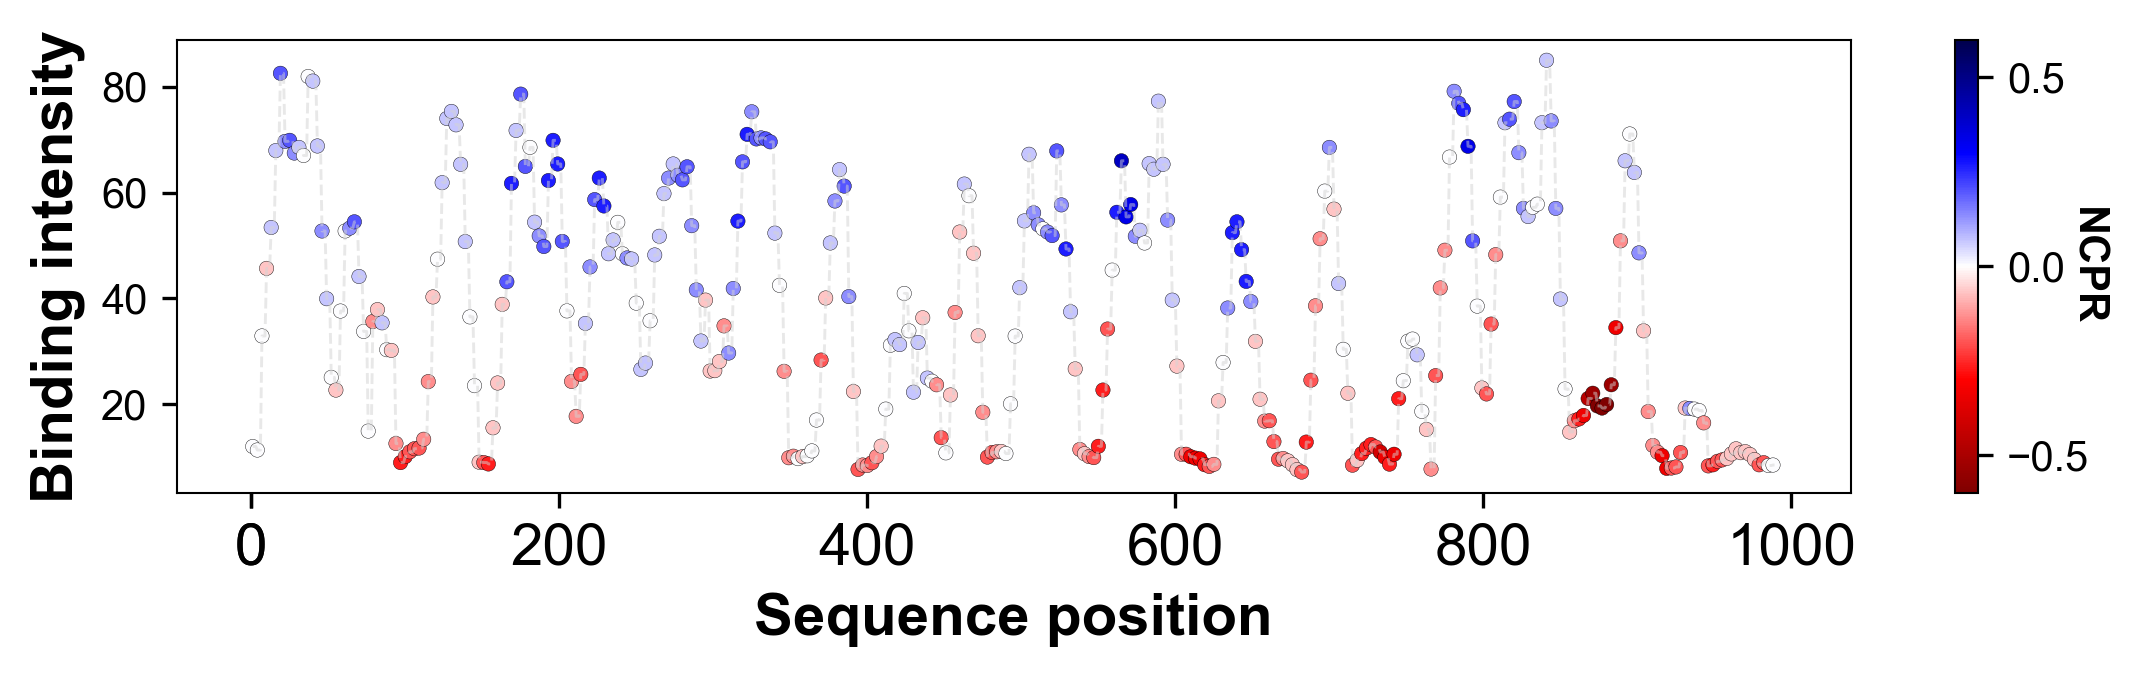

In [20]:
# Fig 3A: affinities combined with NCPR
plt.figure(figsize=(9, 2), dpi=300)
# Avg binding over sequence
plt.scatter(domain[0::3], avg_binding[0::3], c=linNCPR[1][0::3], s=12, cmap='seismic_r', edgecolor='k', linewidth=0.1, vmin=-0.6, vmax=0.6)
plt.plot(domain, avg_binding, color='lightgray', linestyle='--', linewidth=0.7, alpha=0.5)
plt.ylabel('Binding intensity', fontweight='bold', fontsize=14)
plt.xticks([0, 0, 200, 400, 600, 800, 1000], fontsize=14)
plt.xlabel('Sequence position', fontweight='bold', fontsize=14)
cbar = plt.colorbar()
cbar.set_ticks([-0.5,0,0.5])
cbar.set_label('NCPR', rotation=270, fontsize=10, fontweight='bold')
#plt.savefig('S3A_affinity_NCPR')
plt.show()

## FRQ inverse-weighted distance (IWD) residue clustering
* Figure 3B
* Supplemental figures 2A-B

In [15]:
# Helper functions
def map_seq_mask(seq, res):
    """
    this function maps the sequence into a vector
    
    res as list of aa: e.g., ['F', 'Y', 'W']
    
    Input: string sequence 
    Output: a 1 or 0  vector as array matched to string legnth
    """
    mask_res = {}
    for aa in res:
        mask_res[aa] = 1
    
    mask = [0] * len(seq)
    
    # iterate sequence and edit mask
    for i,j in enumerate(seq):
        if j in mask_res:
            mask[i]= mask_res[j]

    return mask

# ------------------------------------------------------------------

def find_all_indicies(test_list, A):
    """
    A = list 
    B = value 
    Returns list of start positions where stringA is in stringB - including overlaps 
    """
    return [i for i, value in enumerate(test_list) if value == A]

# ------------------------------------------------------------------

def calc_average_inverse_distance(seq, res):
    """
    returns average IWD value
    """
    mask = map_seq_mask(seq, res)
    
    # dictionary of empty values for each index point
    all_hits = {i:0 for i in find_all_indicies(mask, 1)} 
    hits = np.array([i for i in all_hits.keys()])
    
    # iterate through index
    for i, p in enumerate(hits):
        resi_distances= 0
        # iterate through pairs for that index 
        for p1 in hits[np.arange(len(hits))!=i]:
            resi_distances += 1 / np.abs(p1-p)

        all_hits[p] = resi_distances
        #print(p,resi_distances)
    
    if len(hits) > 0:
        return sum(all_hits.values())/len(hits)
    else:
        return 0 

# ------------------------------------------------------------------

def shuffle_seq(s):
    """
    Returns a shuffled version of the sequence
    """
    return ''.join(random.sample(s,len(s)))

# ------------------------------------------------------------------
"""
Calculate IWD scores for different residue types
"""
def iwd_aliphatics(s):
    return calc_average_inverse_distance(s, ['M', 'I', 'L', 'V'])

def iwd_aromatics(s):
    return calc_average_inverse_distance(s, ['F', 'Y', 'W'])

def iwd_positives(s):
    return calc_average_inverse_distance(s, ['R', 'K', 'H'])

def iwd_negatives(s):
    return calc_average_inverse_distance(s, ['D', 'E'])

def calc_delta(s):
    return SequenceParameters(s).SeqObj.delta()

# ------------------------------------------------------------------

def calc_dist_and_zscore(seq, func, N=10000):
    """
    Computes some function over a protein sequence and returns a value. 
    Also computes the function for N shuffled variants, and calculates the Z-score of 
    the original sequence using the distribution of values for the random sequences.
    For robust analysis, use N>=10000.
    """
    # Calculate function for target sequence
    target_val = func(seq)
    
    # Get distribution of values for shuffled sequences
    vals = []
    for loop in range(N):
        random_seq = shuffle_seq(seq)       
        vals.append(func(random_seq))
    
    # Get z-score
    z_score = (target_val - np.mean(vals)) / np.std(vals)
        
    return (target_val, z_score, vals)


In [14]:
# Positive residue IWD clustering
#
FRQ_pcluster, pc_zscore, pc_dist = calc_dist_and_zscore(FRQ, iwd_positives, N=1000)

## NOTE: these function takes a while to run with large N (many randomized sequences). 
# Analysis in manuscript used N=10000. For demonstration purposes, this notebook uses N=1000
# Z-score and distribution will change slightly across runs due to stochasticity, especially with smaller N.

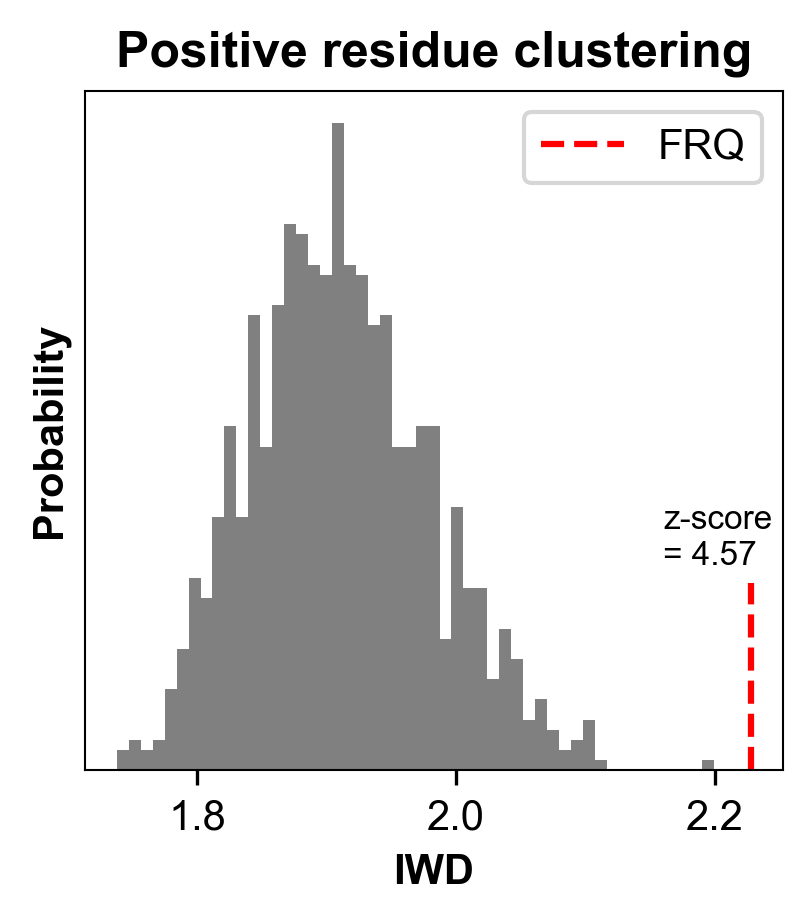

In [16]:
# Figure 3B
plt.figure(figsize=(3,3), dpi=300)
plt.hist(pc_dist, bins=50, density=True, color='gray')
plt.vlines(FRQ_pcluster, 0, 2, colors='r', linestyles='dashed', label='FRQ')
plt.title('Positive residue clustering', fontweight='bold')
plt.yticks([])
plt.ylabel('Probability', fontweight='bold')
plt.xlabel('IWD', fontweight='bold')
plt.text(2.16, 2.2, f'z-score\n= {round(pc_zscore, 2)}', fontsize=8)
plt.legend()

#plt.savefig('Fig3B')
plt.show()

In [17]:
# Negative residue IWD clustering
# Again, manuscript used N=10000, but for efficient demonstration using reduced N here
FRQ_ncluster, nc_zscore, nc_dist = calc_dist_and_zscore(FRQ, iwd_negatives, N=1000)

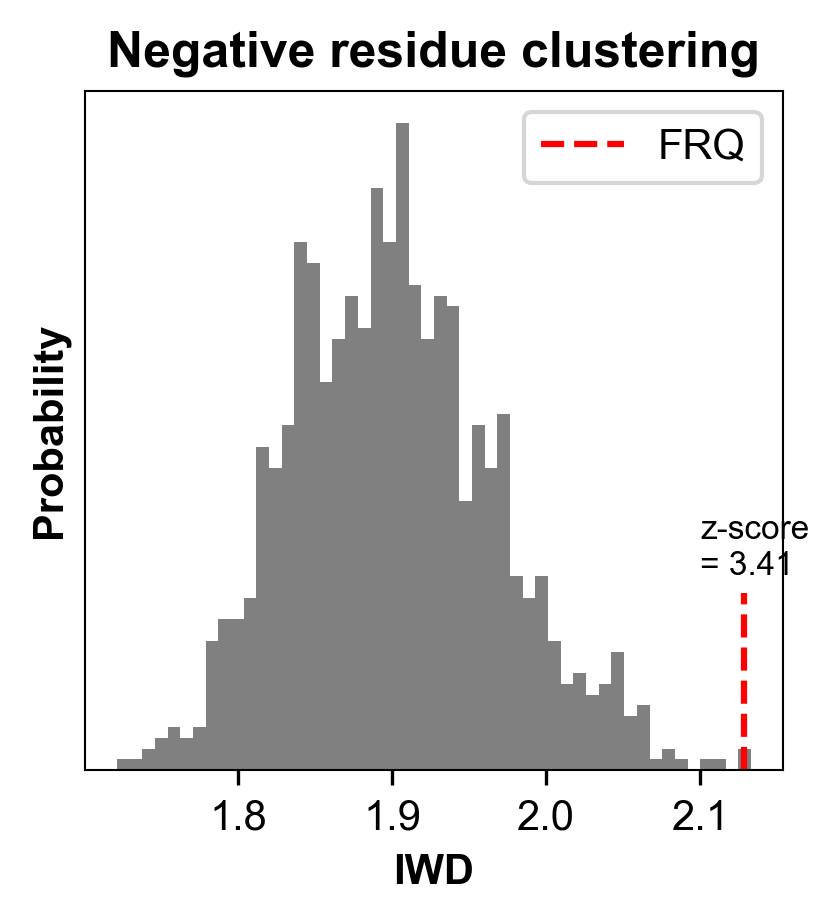

In [18]:
# Supplemental figure 2A
plt.figure(figsize=(3,3), dpi=300)
plt.hist(nc_dist, bins=50, density=True, color='gray')
plt.vlines(FRQ_ncluster, 0, 2, colors='r', linestyles='dashed', label='FRQ')
plt.xlabel('IWD', fontweight='bold')
plt.yticks([])
plt.ylabel('Probability', fontweight='bold')
plt.title('Negative residue clustering', fontweight='bold')
plt.text(2.1, 2.2, f'z-score\n= {round(nc_zscore, 2)}', fontsize=8)
plt.legend()

# plt.savefig('FigS2A')
plt.show()

In [19]:
# Aromatic residue IWD clustering
FRQ_aromcluster, aromc_zscore, aromc_dist = calc_dist_and_zscore(FRQ, iwd_aromatics, N=1000)

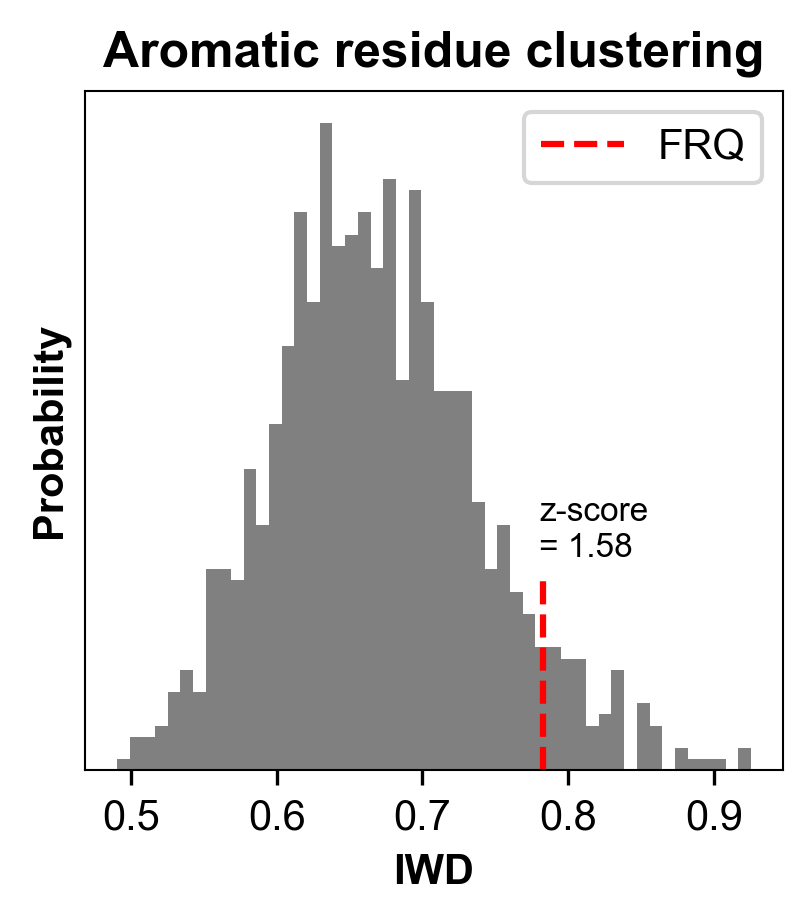

In [20]:
# Supplemental figure 2B
plt.figure(figsize=(3,3), dpi=300)
plt.hist(aromc_dist, bins=50, density=True, color='gray')
plt.vlines(FRQ_aromcluster, 0, 2, colors='r', linestyles='dashed', label='FRQ')
plt.xlabel('IWD', fontweight='bold')
plt.yticks([])
plt.ylabel('Probability', fontweight='bold')
plt.title('Aromatic residue clustering', fontweight='bold')
plt.text(0.78, 2.2, f'z-score\n= {round(aromc_zscore, 2)}', fontsize=8)
plt.legend()

# plt.savefig('FigS2B')
plt.show()

## Ortholog IWD comparisons
* Figure 3C
* Supplemental figure 3A

In [21]:
# Ortholog sequences and IWDs used in manuscript
per_ortholog_seqs = protfasta.read_fasta('data/per_orthologs.fasta')
fungal_ortholog_seqs = protfasta.read_fasta('data/fungal_orthologs.fasta')
per_ortholog_IWDs = pd.read_csv('data/per_orthologs_iwd_zscores.csv')
fungal_ortholog_IWDs = pd.read_csv('data/fungal_orthologs_iwd_delta_zscores.csv')

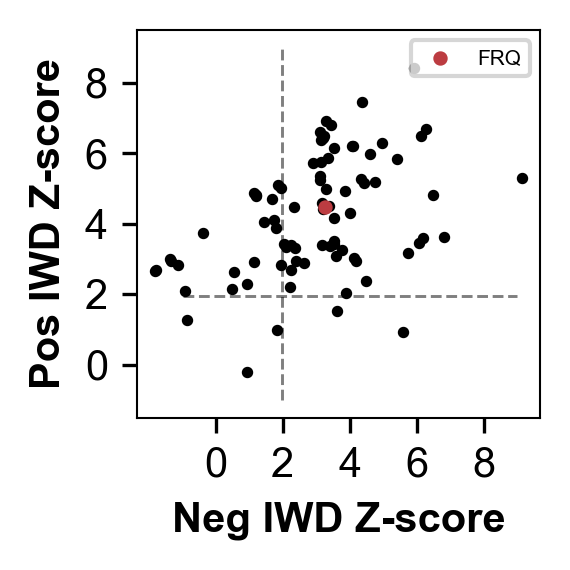

In [22]:
# Figure S3A: FRQ and fungal orthologs
x = fungal_ortholog_IWDs['neg_clust'].values
y = fungal_ortholog_IWDs['pos_clust'].values

plt.figure(figsize=(2,2), dpi=300)
plt.scatter(x[:-1], y[:-1], s=3, color='k')
plt.scatter(x[-1], y[-1], s=6, color='#BC3C41', label='FRQ')
plt.hlines(1.96, -1, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5)
plt.vlines(1.96, -1, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5)
plt.xlabel('Neg IWD Z-score', fontweight='bold')
plt.ylabel('Pos IWD Z-score', fontweight='bold')
plt.xticks([0,2,4,6,8])
plt.yticks([0,2,4,6,8])

plt.legend(loc='upper right', fontsize=5)
plt.tight_layout()

# plt.savefig('S3A')
plt.show()

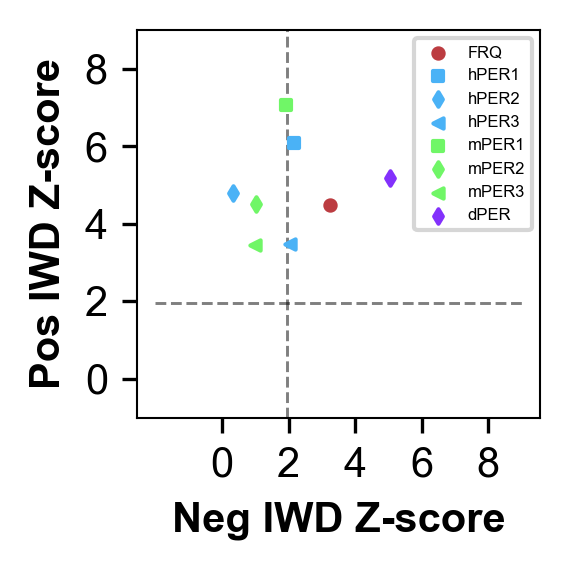

In [23]:
# Figure 3C: FRQ and PER orthologs
fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi=300)

per_pos = per_ortholog_IWDs['pos_IWD'].values
per_neg = per_ortholog_IWDs['neg_IWD'].values
plt.scatter(x[-1], y[-1], s=6, color='#BC3C41', label='FRQ', zorder=3)
ax.scatter(per_neg[0], per_pos[0], marker='s', color='#4AB2F6', s=6, label='hPER1', zorder=3)
ax.scatter(per_neg[1], per_pos[1], marker='d', color='#4AB2F6', s=6, label='hPER2', zorder=3)
ax.scatter(per_neg[2], per_pos[2], marker='<', color='#4AB2F6', s=6, label='hPER3', zorder=3)
ax.scatter(per_neg[3], per_pos[3], marker='s', color='#70F667', s=6, label='mPER1', zorder=3)
ax.scatter(per_neg[4], per_pos[4], marker='d', color='#70F667', s=6, label='mPER2', zorder=3)
ax.scatter(per_neg[5], per_pos[5], marker='<', color='#70F667', s=6, label='mPER3', zorder=3)
ax.scatter(per_neg[6], per_pos[6], marker='d', color='#8331FC', s=6, label='dPER', zorder=3)

ax.set_ylim([-1,9])
ax.hlines(1.96, -2, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5, zorder=1)
ax.vlines(1.96, -1, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5, zorder=1)
ax.set_xlabel('Neg IWD Z-score', fontweight='bold')
ax.set_ylabel('Pos IWD Z-score', fontweight='bold')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,2,4,6,8])

plt.tight_layout()
ax.legend(fontsize=4)

# plt.savefig('Fig3C')
plt.show()

## FFD point mutant table
* Figure 4D

In [24]:
# load data
table = np.loadtxt('data/ffd_mutant_table.tsv', dtype='str')
ffd = table[0, 1:]
AAs = table[1:, 0]
table = np.genfromtxt([v.replace('*', 'np.nan') for v in table[1:, 1:].flatten()]).reshape(20, 15)
table = table * 64 / 100 + 64

In [25]:
log_table = np.log2(table / 64)

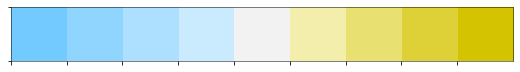

In [26]:
sns.palplot(sns.diverging_palette(235, 78, s=100, l=78, sep=2, n=9))
cmap = sns.diverging_palette(235, 78, s=100, l=78, sep=2, n=9, as_cmap=True)

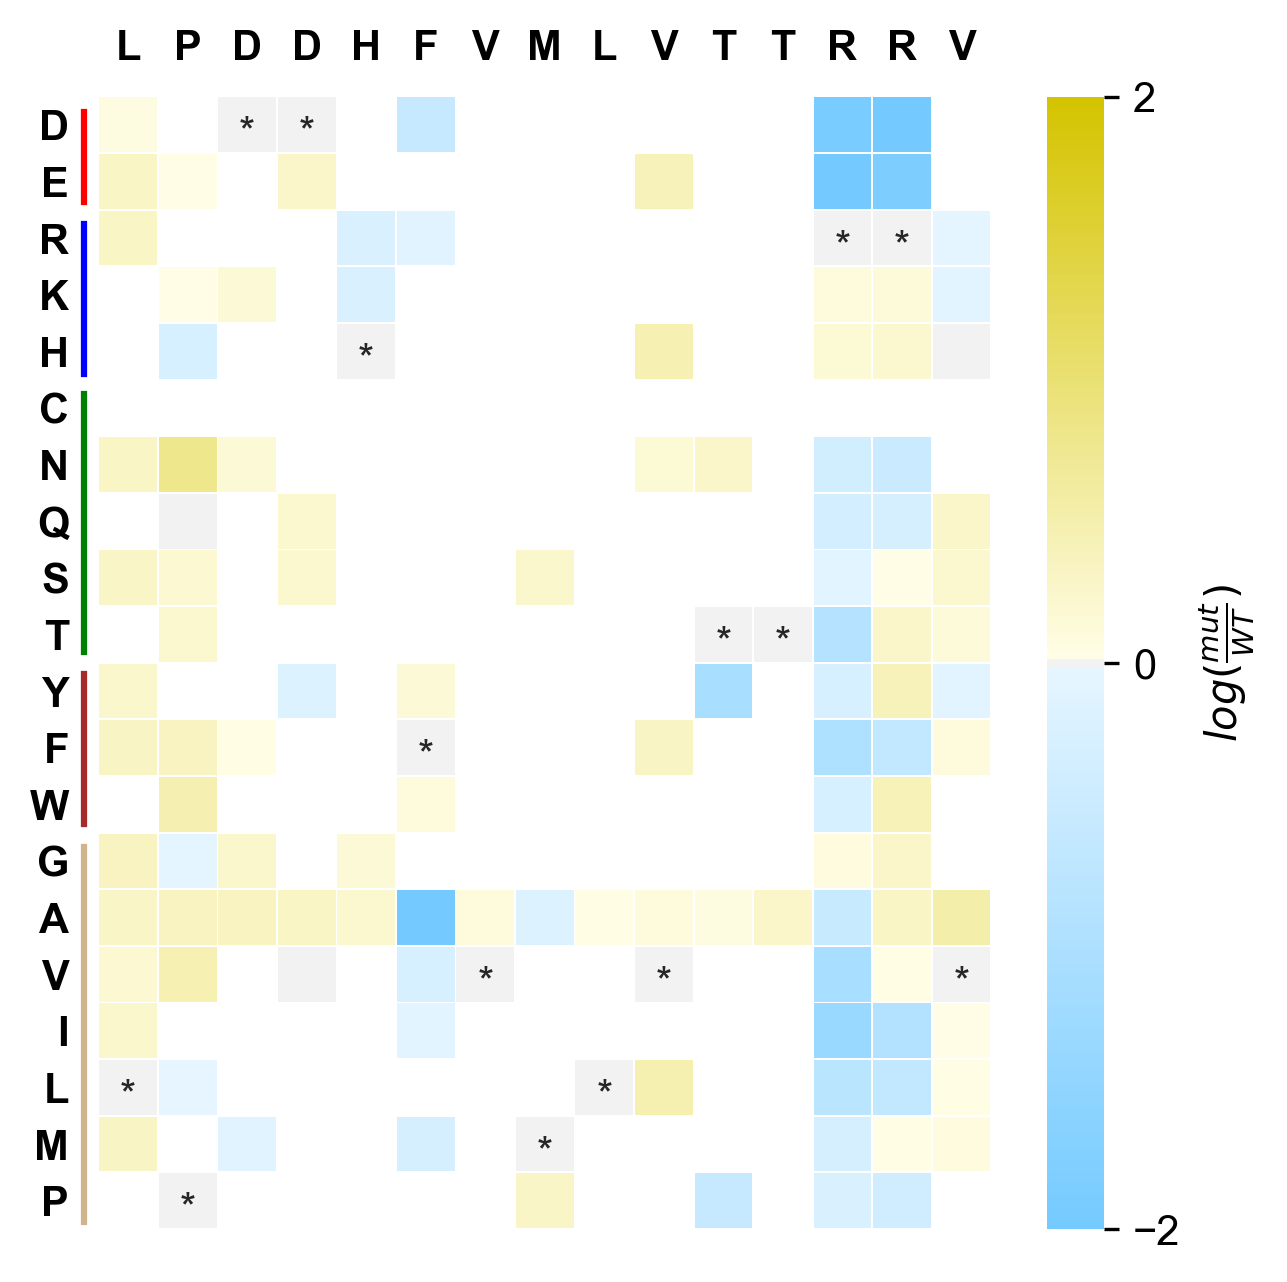

In [27]:
fig = plt.figure(figsize=(4.8,5), dpi=300)

labels = np.full((20, 15), fill_value='')
for loc in [(17,0),(19,1),(0,2),(0,3),(4,4),(11,5),(15,6),(18,7),(17,8),(15,9),(9,10),(9,11),(2,12),(2,13),(15,14)]:
    labels[loc[0], loc[1]] = '*'

fig.add_artist(lines.Line2D([0.115, 0.115], [0.87, 0.81], c='r'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.795, 0.695], c='b'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.682, 0.51], c='g'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.495, 0.395], c='brown'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.38, 0.13], c='tan'))

akws = {"va": 'bottom'}
ax = sns.heatmap(log_table, vmin=-2, vmax=2, center=0, cmap=cmap, linewidth=0.2, 
                 annot=labels, fmt='', annot_kws=akws, cbar_kws={"ticks":[-2,0,2], "label" : r'$log(\frac{mut}{WT})$'})
ax.xaxis.tick_top()
ax.set_xticklabels(ffd, fontweight='bold')
ax.set_yticklabels(AAs, rotation=0, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, 
                top = False, labeltop=True, left=False)

for t in ax.texts:
    trans = t.get_transform()
    offs = matplotlib.transforms.ScaledTranslation(0, 0.5,
                    matplotlib.transforms.IdentityTransform())
    t.set_transform( offs + trans )


# plt.savefig('Figure4D')
plt.show()